In [1]:
# EDA resource: Tanu N Prabhu
# Url: https://towardsdatascience.com/exploratory-data-analysis-in-python-c9a77dfa39ce 

# Outleir removal resource: Natasha Sharma
# Url: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

# Importing required libraries.
import pandas as pd
import numpy as np
import os
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

path = os.getcwd()

## Step 1. Preparation

In [2]:
# Import the training dataset. 
train_df = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [4]:
# Check the data types of the variables
train_df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [5]:
# Split data into numeric and categorical
num_cols=[col for col in train_df.columns if (train_df[col].dtype in ("int64", "float64"))]
categ_col=[col for col in train_df.columns if (train_df[col].dtype =='object')]

## Step 2. Visualization

Text(0.5, 0, 'Sale Price ($)')

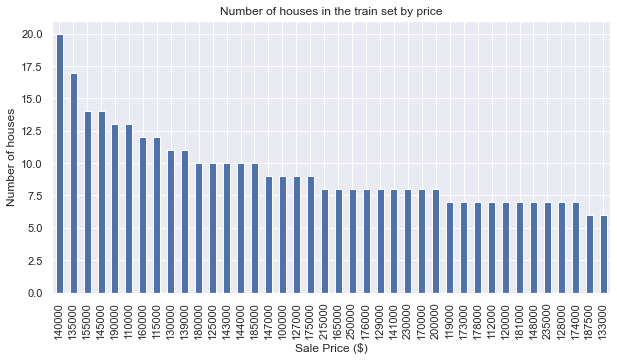

In [6]:
train_df.SalePrice.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Number of houses in the train set by price")
plt.ylabel("Number of houses")
plt.xlabel("Sale Price ($)")

## Step 3. Outliers in Numerical Variables

In [7]:
# Dependent variable needs not to be cleaned.
num_cols = num_cols[:-1]
print("Number of numerical variables: ", len(num_cols))

Number of numerical variables:  37


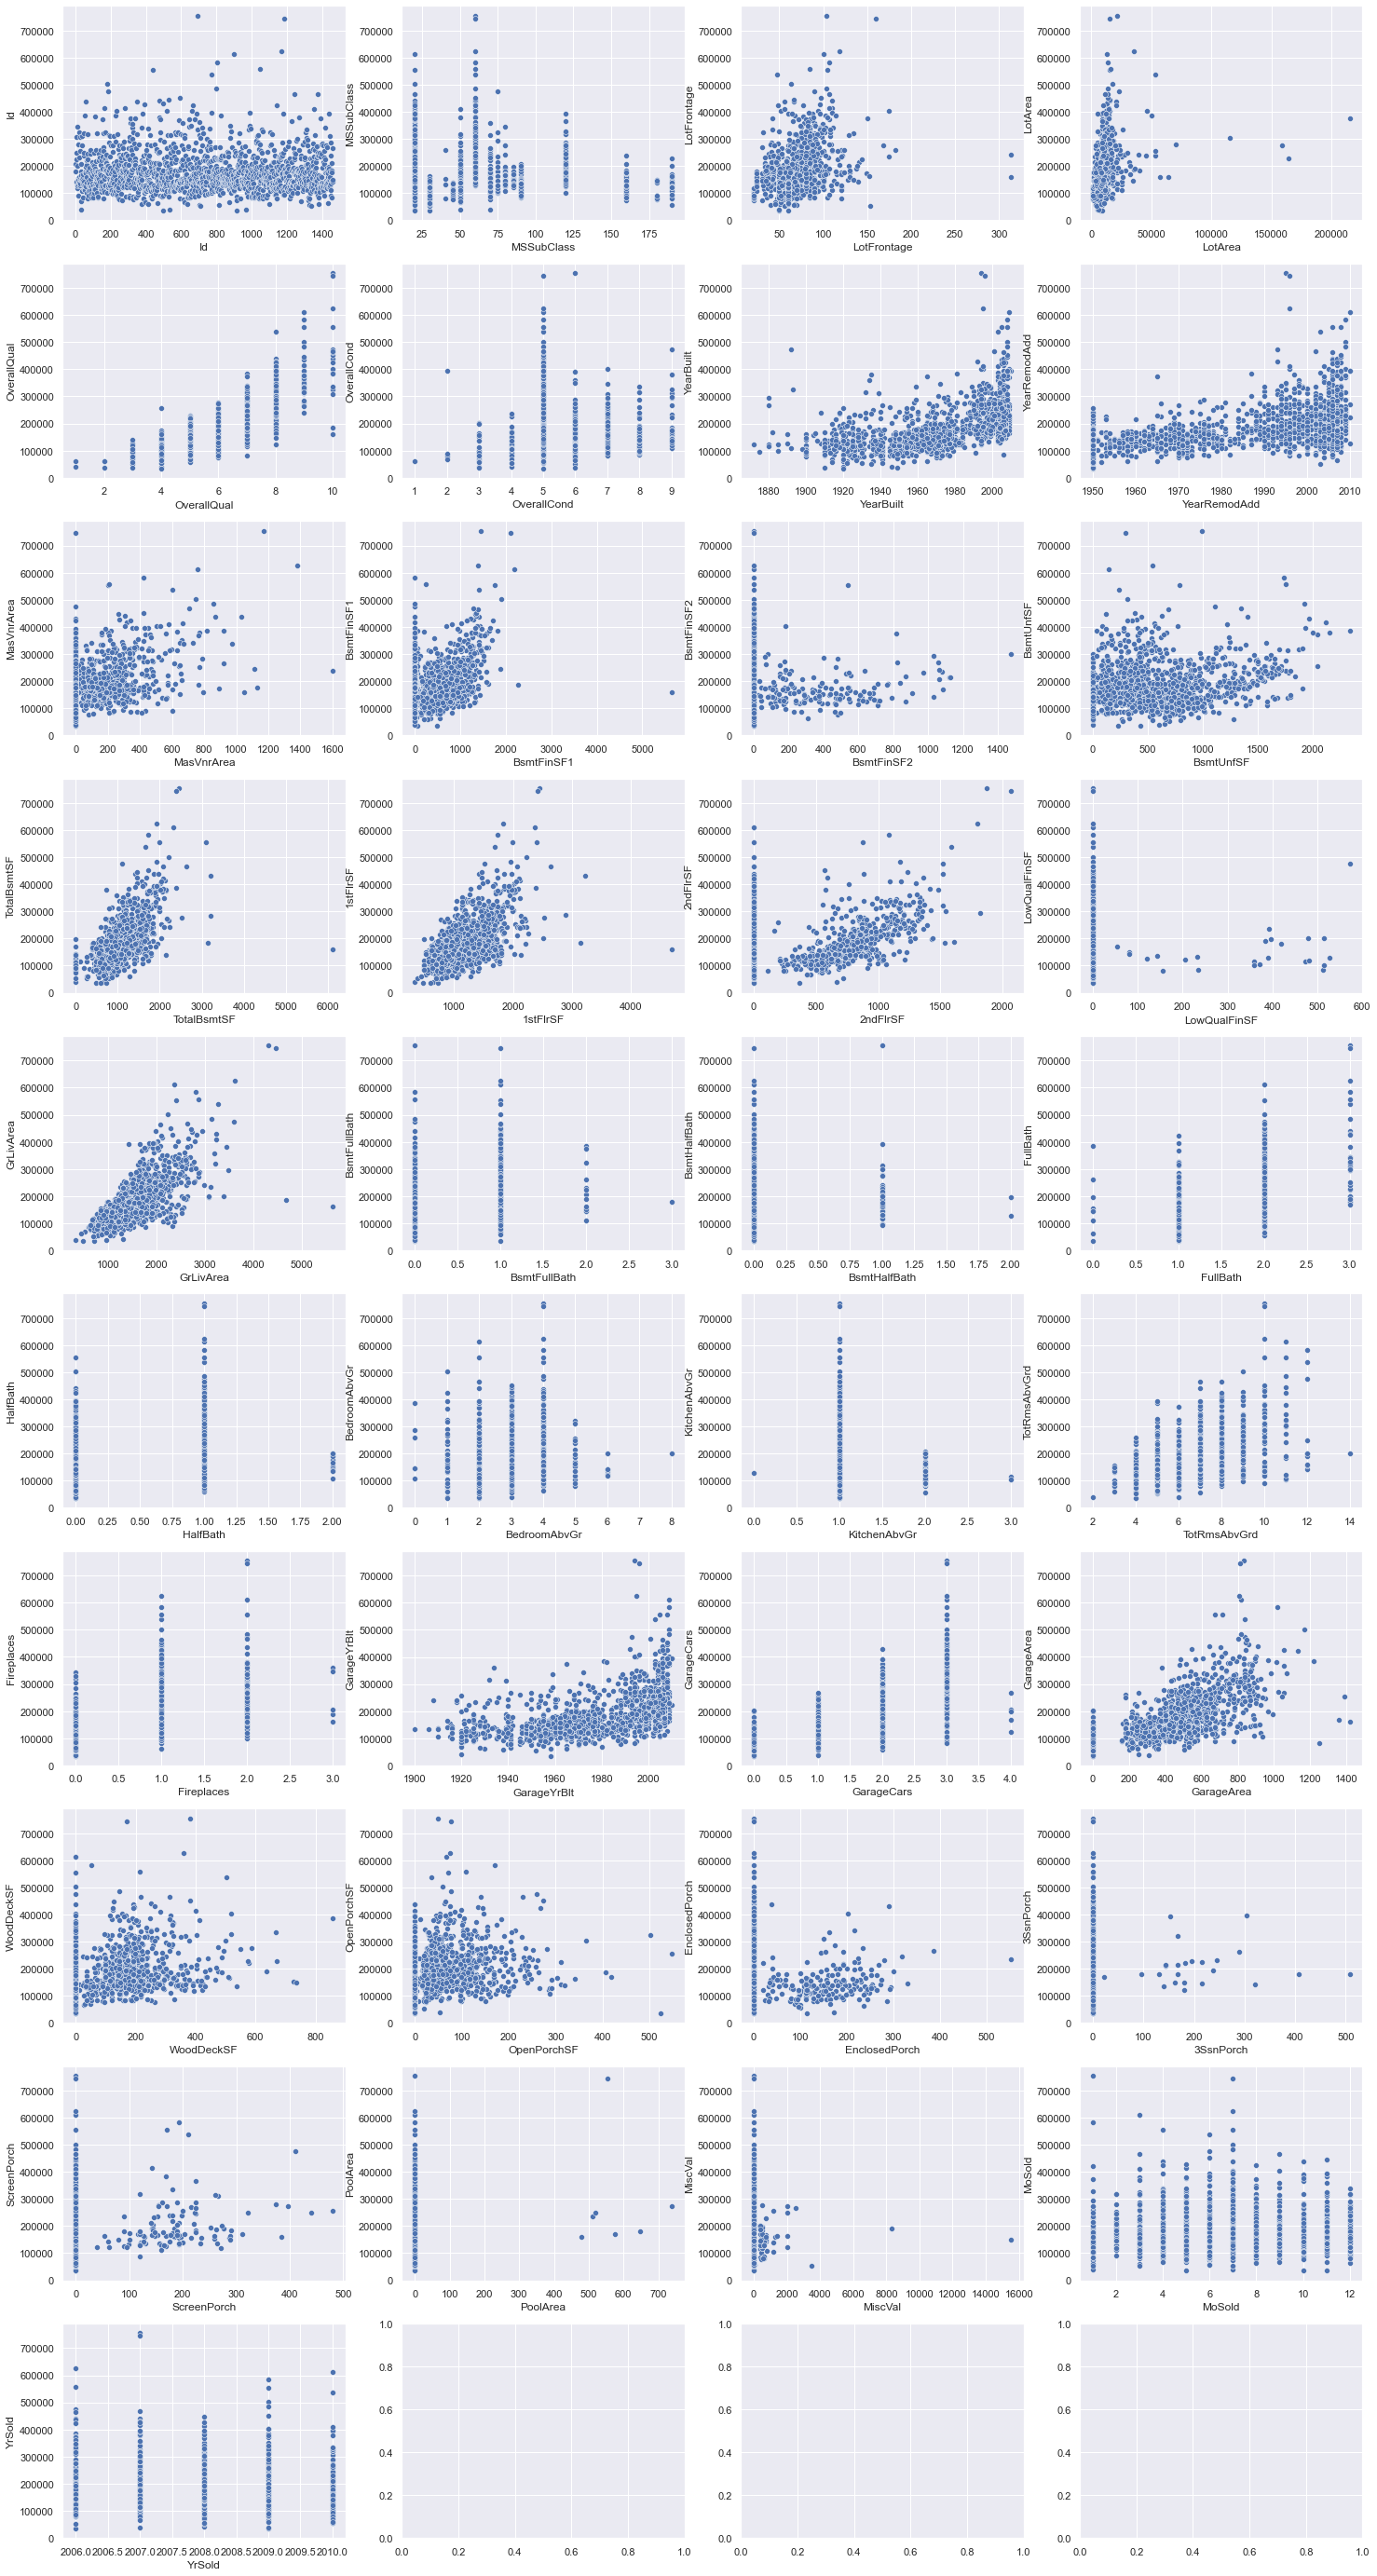

In [8]:
#To see the distribution of num data in relation to the price
fig, ax = plt.subplots(10,4,figsize=(25,50))
ax=ax.flatten()
for i, col in enumerate(num_cols):
    sns.scatterplot(y='SalePrice', x=col, ax=ax[i], data=train_df)
    ax[i].set_ylabel(col)
plt.show()

There are a few observations can be made from the scatter plots: 
1. Some of the numerical variables are actually discrete variables, such as MSSubClass where the houses are divided into a number of classes. Transforming them into categorical variables may help improve the accuracy of the model. 
2. Some of the numerical variables have most of their values being 0, such as LowQUalFinSF. Converting it to a binary variable can be beneficial. 
3. A few numerical variables have outliers that may attribute to a less accurate model. These outlier observations need to be taken out. 

### Step 3.1. Converting to binary variables

In [9]:
# Convert variables who have more than 50% of its values 
for column in train_df[num_cols]:
    value_list = train_df[column].values
    count = 0
    for i in value_list:
        if i == 0:
            count += 1
    if count >= 0.5*len(value_list):
        train_df[column] = train_df.apply(lambda x: 0 if x[column] == 0 else 1, axis=1)
        test_df[column] = test_df.apply(lambda x: 0 if x[column] == 0 else 1, axis=1)
        
num_cols = [col for col in train_df[num_cols].columns if (len(train_df[col].unique()) > 3)]
print("Number of numerical variables left: ", len(num_cols))

Number of numerical variables left:  24


## Step 3.2. Converting to categorical variables

In [10]:
# Convert numeric variables who have less than 20 distinct values into objective variables. 
for column in train_df[num_cols]:
    distinct_value = train_df[column].unique()
    if len(distinct_value)<17:
        train_df[column] = train_df[column].fillna(0)
        test_df[column] = test_df[column].fillna(0)
        train_df[column] = train_df[column].astype(int)
        test_df[column] = test_df[column].astype(int)
        train_df[column] = train_df[column].astype(str)
        test_df[column] = test_df[column].astype(str)

num_cols = [col for col in train_df[num_cols].columns if (train_df[col].dtype in ("int64", "float64"))]
num_cols = num_cols[:-1]
print("Number of numerical variables left: ", len(num_cols))

Number of numerical variables left:  12


### Step 3.3. Removing outliers

In [11]:
# Initial size of the dataframe:
train_df.shape

(1460, 81)

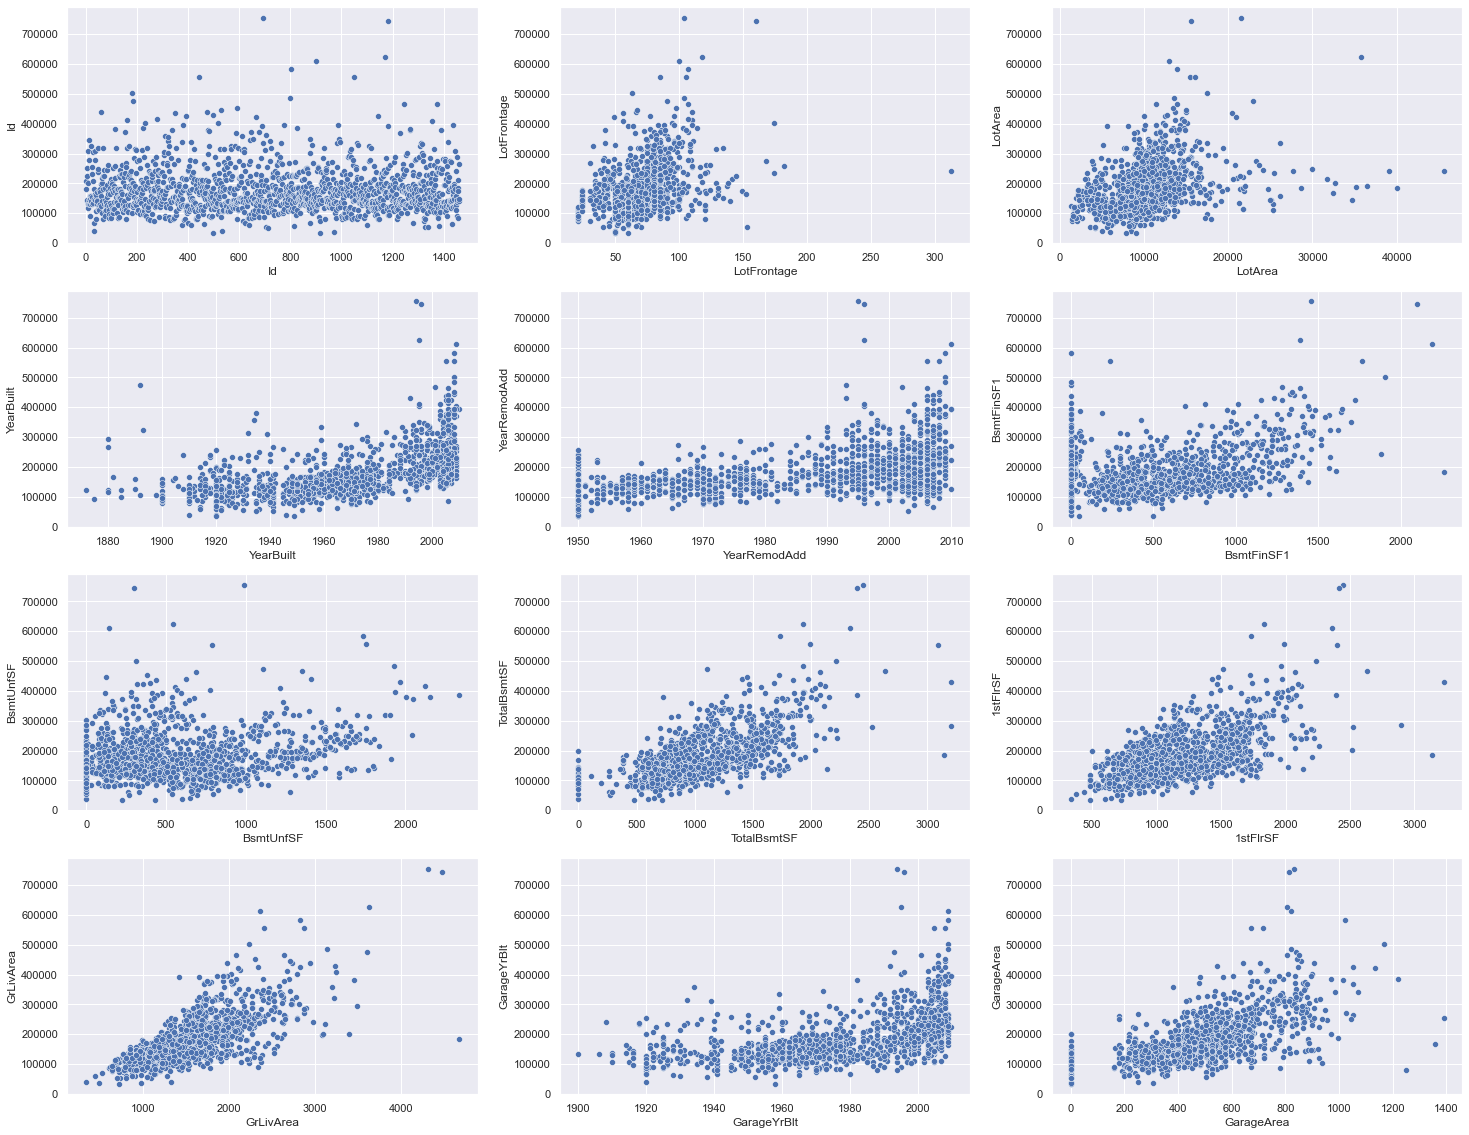

In [12]:
# Going variable by variable to eliminate outliers.
for column in train_df[num_cols]:
    value_list = train_df[column].values
    q1, q3= np.percentile(value_list,[25,75])
    iqr = q3 - q1
    lower_bound = q1 - (3 * q1)
    upper_bound = q3 + (3 * q3)

    for j in value_list:
        if j > upper_bound:
            i = train_df[(train_df[column]== j)].index
            train_df = train_df.drop(i)
        elif j < lower_bound:
            i = train_df[(train_df[column] == j)].index
            train_df = train_df.drop(i)
        else:
            pass

#To see the distribution of num data in relation to the price
fig, ax = plt.subplots(4,3,figsize=(25,20))
ax=ax.flatten()
for i, col in enumerate(num_cols):
    sns.scatterplot(y='SalePrice', x=col, ax=ax[i], data=train_df)
    ax[i].set_ylabel(col)
plt.show()   

In [13]:
# The dataframe share after outliers are removed: 
train_df.shape

(1448, 81)

## Step 4. Deal with Missing Values:

In [14]:
# Convert the categorical variables into dummy variables
train_df = pd.get_dummies(train_df, dummy_na=False)
test_df = pd.get_dummies(test_df, dummy_na=False)

# There are still three variables have missing values:
# Deal with LotFrontage - filled with 0. 
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(0)
test_df['LotFrontage'] = test_df['LotFrontage'].fillna(0)

# Deal with GarageYrBlt - Delete (Garage year built is probably not important)
del train_df['GarageYrBlt']
del test_df['GarageYrBlt']

# Delete ID column
del train_df['Id']
del test_df['Id']

# Deal with MasVnrArea
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(0)

# Move the dependent variable to the end of the dataframe
train_df = train_df[[c for c in train_df if c not in ['SalePrice']] 
       + ['SalePrice']]

In [15]:
# Remove the additional variables that the test set has.
var_list = list(set(test_df.columns).difference(train_df.columns))
test_df = test_df.drop(var_list, axis = 1)

# Add the variables that the train set has but test set doesn't.
var_list = list(set(train_df.columns).difference(test_df.columns))
for i in var_list:
    test_df[i] = 0

In [16]:
train_df.shape

(1448, 364)

In [17]:
test_df.shape

(1459, 364)

## Step 5. Save the csv files

In [18]:
train_df.to_csv(path + '\\train_cleaned.csv', index = False)
test_df.to_csv(path + '\\test_cleaned.csv', index = False)